In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.linalg import solve_continuous_lyapunov
np.set_printoptions(precision=5, suppress=True)
import time

In [2]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3] 
    J = np.array([[-params[0], params[2]], [-params[0]*c, -params[1]]])
    B = np.diagflat(params[-2:])**2 
    return J, B 

def get_B(B0, b, c, h_dot_det):
    g = c-3*b*(h_dot_det**2)
    Dh = B0[0, 0]
    Bt = np.copy(B0) 
    Bt[1, 0] += g*Dh
    Bt[0, 1] = Bt[1, 0] 
    Bt[1, 1] += g*g*Dh + 6*b**2*Dh**3 
    return Bt

def get_B_array(B0, b, c, h_dot_det): 
    '''
    h_dot_det: array of size 2 x N 
    B0: matrix of size 2 x 2 
    '''
    g = c-3*b*(h_dot_det**2)
    Dh = B0[0, 0]
    N = len(h_dot_det)
    Bt = np.zeros((N, 2, 2))
    Bt += B0[np.newaxis, :, :] 
    Bt[:, 1, 0] += g*Dh 
    Bt[:, 0, 1] = Bt[:, 1, 0] 
    Bt[:, 1, 1] += g*g*Dh + 6*b**2*Dh**3 
    return Bt

In [3]:
class nonlinear_model(): 
    
    def __init__(self, params):
        self.J, self.B = convert_params(params)
        self.b = params[4]
        self.c = params[3] 
        
    def evolve(self, T, dt, n_frames, n_repeats):
        results = [] 
        for n in range(n_repeats): 
            y = np.zeros((2))
            res = np.zeros((n_frames, 2))
            for i in range(n_frames):
                for j in range(int(T/n_frames/dt)):
                    self._update(y, dt)
                res[i] = np.copy(y)
            results.append(res.T) 
        return results 


    def _update(self, y, dt):
        det = self.J @ y 
        det[1] -= self.b*det[0]**3 
        Bt = get_B(self.B, self.b, self.c, det[0])
        sto = np.sqrt(dt)*np.random.multivariate_normal([0, 0], Bt)
        y += det*dt + sto 

In [14]:
class inference():
    
    def __init__(self):
        pass 
    
    def inf(self, guess, trajs, dt, bounds=None, brute_force=False, method='trust-constr'):   
        cost = lambda x: self._minuslogP(x, trajs, dt)
        if bounds is None: 
            bounds = [[1e-6, 10]]*len(guess)
        if brute_force: 
            res = brute(cost, bounds, Ns=100)
            MAP, cost = res[0], res[1]
        else: 
            res = minimize(cost, guess, bounds=bounds, method=method)
            MAP, cost = res.x, res.fun 
        return MAP, cost
                   
    def _minuslogP(self, params, trajs, dt):
        '''
        traj: 2 x T 
        '''
        J, B = convert_params(params)
        b = params[4] 
        c = params[3]
        # Bt = get_B(B, b, c, 0)
        # invB = np.linalg.inv(B*dt) 
        # _, norm = np.linalg.slogdet(invB)

        minuslogp = 0 
        for traj in trajs: 
            N = traj.shape[-1] - 1
            dx = traj[:, 1:] - traj[:, :-1]
            det = J @ traj[:, :-1]
            det[1] -= b*det[0]**3 
            diff = dx - det*dt 
            Bt = get_B_array(B, b, c, det[0])
            invB = np.linalg.inv(Bt*dt) 
            _, norm = np.linalg.slogdet(invB)
            
            minuslogp += np.einsum('ji,ijk,ki', diff, invB, diff)/2 
            minuslogp -= np.sum(norm)/2
            # minuslogp += np.einsum('ji,jk,ki', diff, invB, diff)/2 
            # minuslogp -= N*norm/2
        return minuslogp

    def std_error(self, MAP, trajs, dt, delta=1e-3):
        cost = lambda x: self._minuslogP(x, trajs, dt)
        temp = np.copy(MAP)
        delta = MAP*delta 
        hess = np.empty((len(MAP), len(MAP)))
        for i in range(len(MAP)):
            for j in range(i, len(MAP)):
                temp[i] += delta[i]
                temp[j] += delta[j]
                hess[i, j] = cost(temp) # ++ 
                temp[j] -= 2*delta[j]
                hess[i, j] -= cost(temp) # +- 
                temp[i] -= 2*delta[i]
                hess[i, j] += cost(temp) # -- 
                temp[j] += 2*delta[j]
                hess[i, j] -= cost(temp) # -+
                hess[i, j] /= (4*delta[i]*delta[j])
                hess[j, i] = hess[i, j]   
        return np.sqrt(np.diagonal(np.linalg.inv(hess))), hess

### First, we make some simulations with known parameters and infer them with both inference methods

In [18]:
# params in order of [epsilon, gamma-mu*c, mu, c]
T = 5
dt = 5e-3
n_frames = T/dt
n_repeats = 3

#  lambda, gamma, mu, c, b, sigma_d, sigma_p  
params = [0.1, 2.5, 0.2, 10, 1, 0.025, 0.787]
# J, B = convert_params(params)
# print(J)
# print(B)
# print(np.linalg.eigvals(J))

m = nonlinear_model(params)
results = m.evolve(T, dt, int(n_frames), n_repeats)

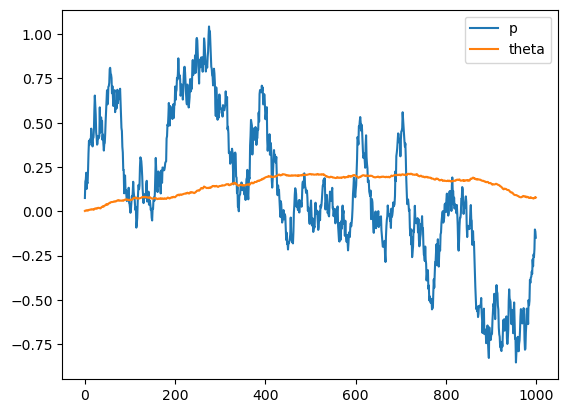

In [19]:
plt.plot(results[0][1], label='p')
plt.plot(results[0][0], label='theta')
plt.legend() 
plt.show()

In [20]:
inf = inference()

t1 = time.time() 
minuslogp = inf._minuslogP(params, results, T/n_frames)
t2 = time.time() 
print('time taken: ', t2-t1)
print(minuslogp)

time taken:  0.012456893920898438
-24628.695383168022


In [21]:
## Numerical inference
inf = inference()
guess = [1, 1, 1, 1, 2, 0.1, 0.1]
bounds = [[1e-6, None]]*7
MAP, cost = inf.inf(guess, results, (T/n_frames), bounds=bounds)
print(MAP, cost)
print('true params:', params, inf._minuslogP(params, results, T/n_frames))

[ 0.09088  2.0203   0.1919  10.11717  2.49548  0.02503  0.79281] -24629.638182982802
true params: [0.1, 2.5, 0.2, 10, 1, 0.025, 0.787] -24628.695383168022


In [22]:
std_err, hess = inf.std_error(MAP, results, T/n_frames, delta=1e-4)
print('standard error:', std_err)

standard error: [ 0.06616  0.52794  0.01583  0.74373 24.48584  0.00032  0.01026]


In [23]:
path = 'Data/N11_ThetaPola_DATA/'
files = [f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(path+f)['POLA'])
    else: 
        theta_trajs.append(loadmat(path+f)['THETAd'])

N11_1_R200_B30_04_05_POLARIZATION.mat N11_1_R200_B30_04_05_ThetaTime.mat
N11_1_R200_B50_04_05_POLARIZATION.mat N11_1_R200_B50_04_05_ThetaTime.mat
N11_1_R200_B50_25_04_POLARIZATION.mat N11_1_R200_B50_25_04_ThetaTime.mat
N11_1_R200_B50_26_04_POLARIZATION.mat N11_1_R200_B50_26_04_ThetaTime.mat
N11_2_R200_B50_26_04_POLARIZATION.mat N11_2_R200_B50_26_04_ThetaTime.mat
N11_3_R200_B50_25_04_POLARIZATION.mat N11_3_R200_B50_25_04_ThetaTime.mat
N11_4_R200_B100_25_04_POLARIZATION.mat N11_4_R200_B100_25_04_ThetaTime.mat
N11_4_R200_B30_25_04_POLARIZATION.mat N11_4_R200_B30_25_04_ThetaTime.mat
N11_4_R200_B50_25_04_POLARIZATION.mat N11_4_R200_B50_25_04_ThetaTime.mat
N11_5_R200_B30_25_04_POLARIZATION.mat N11_5_R200_B30_25_04_ThetaTime.mat
N11_5_R200_B50_25_04_POLARIZATION.mat N11_5_R200_B50_25_04_ThetaTime.mat


In [24]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))
theta_trajs.pop(2);
pol_trajs.pop(2); 
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))
print([(theta[1, 0], p[1, 0]) for (theta, p) in zip(theta_trajs, pol_trajs)])
dt = theta_trajs[0][0, 0]
print('dt = ', dt)

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]
[(0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667), (0.06666666666666667, 0.06666666666666667)]
dt =  0.03333333333333333


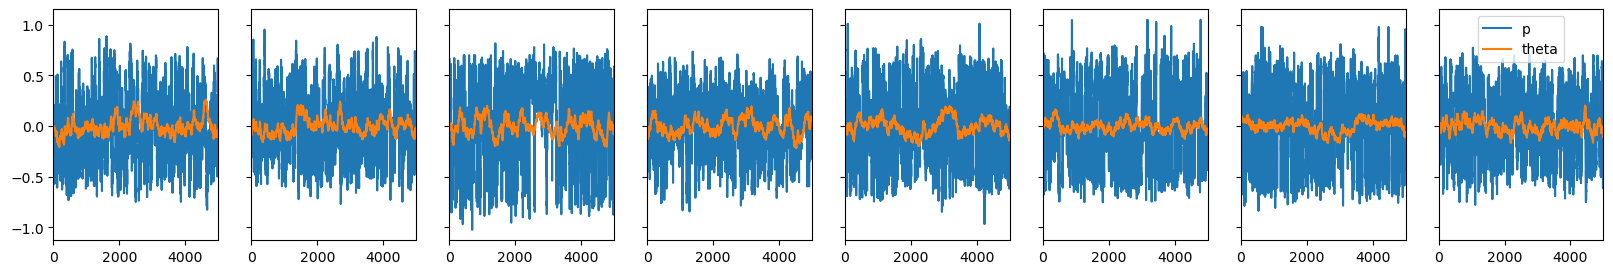

In [25]:
f1 = lambda x: (x[:, 1] - np.mean(x[:, 1]))/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: x[:, 2] - np.mean(x[:, 2])

data = [np.stack([f1(theta), f3(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, figsize=(20, 3))

i = 0 
for d in data: 
    if len(d[1]) == 5000: 
        axes[i].plot(d[1], label='p')
        axes[i].plot(d[0], label='theta')
        i += 1 
axes[0].set_xlim([0, 5000])
plt.legend()
plt.show()

In [26]:
linear_map = [0.089, 2.537, 0.176, 3.574, 0, 0.025, 0.787]
guess = [0.1, 1, 0.1, 30, 10, 0.02, 1]
bounds = [[0, None]]*7 
inf = inference()
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
print(MAP, y)
print(linear_map, inf._minuslogP(linear_map, data, dt))

[0.09987 2.4196  0.16829 6.01261 9.85896 0.02554 0.74509] -281820.30509977776
[0.089, 2.537, 0.176, 3.574, 0, 0.025, 0.787] -281533.0303757297


In [27]:
std_err, hess = inf.std_error(MAP, data, dt, delta=1e-4)
print('fractional error:', std_err/MAP)
print('absolute error:', std_err)
print(np.linalg.eigvals(hess)) # check that all eigenvalues of the Hessian are positive 

fractional error: [0.0905  0.0239  0.01125 0.03111 1.1874  0.00336 0.00337]
absolute error: [ 0.00904  0.05782  0.00189  0.18707 11.70657  0.00009  0.00251]
[1.35488e+08 2.92590e+05 1.59078e+05 1.22511e+04 3.15632e+02 5.21299e+01
 7.29609e-03]


In [28]:
n_frames = 5000
m = nonlinear_model(MAP)
print(m.J, m.b)
n_repeats = 8
sims = m.evolve(n_frames*dt, 3.3e-3, n_frames, n_repeats)

[[-0.09987  0.16829]
 [-0.60045 -2.4196 ]] 9.858957796625262


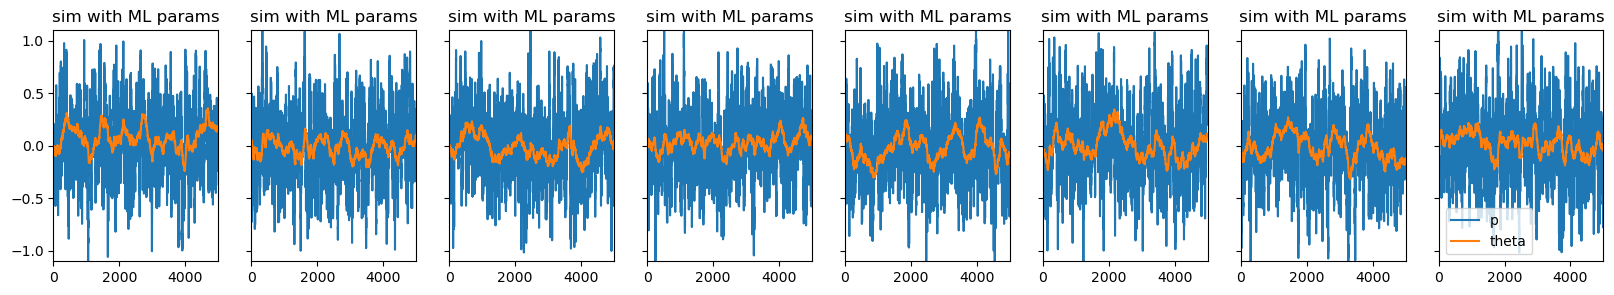

In [30]:
fig, axes = plt.subplots(1, len(sims), sharex=True, sharey=True, figsize=(20, 3))
for (i, s) in enumerate(sims): 
    axes[i].plot(s[1], label='p')
    axes[i].plot(s[0], label='theta')
    axes[i].set_title('sim with ML params')
axes[0].set_ylim([-1.1, 1.1])
axes[0].set_xlim([0, 5000])
plt.legend()
plt.show() 

In [59]:
MAP2, y2 = inf.inf(MAP, sims, dt, bounds=bounds)
std_err, hess = inf.std_error(MAP2, sims, dt, delta=1e-4)
print(MAP, inf._minuslogP(MAP, sims, dt))
print(MAP2, y2)
print(std_err)

[ 0.09473  2.38254  0.16884  5.48681 32.81625  0.02554  0.74518] -256488.4075519913
[ 0.09148  2.21982  0.16293  7.15607 38.22874  0.02572  0.69948] -256724.25133828135
[ 0.00552  0.06005  0.00208  0.17751 10.44214  0.00009  0.00248]


(9534.0967925017+7443.205338913956j)


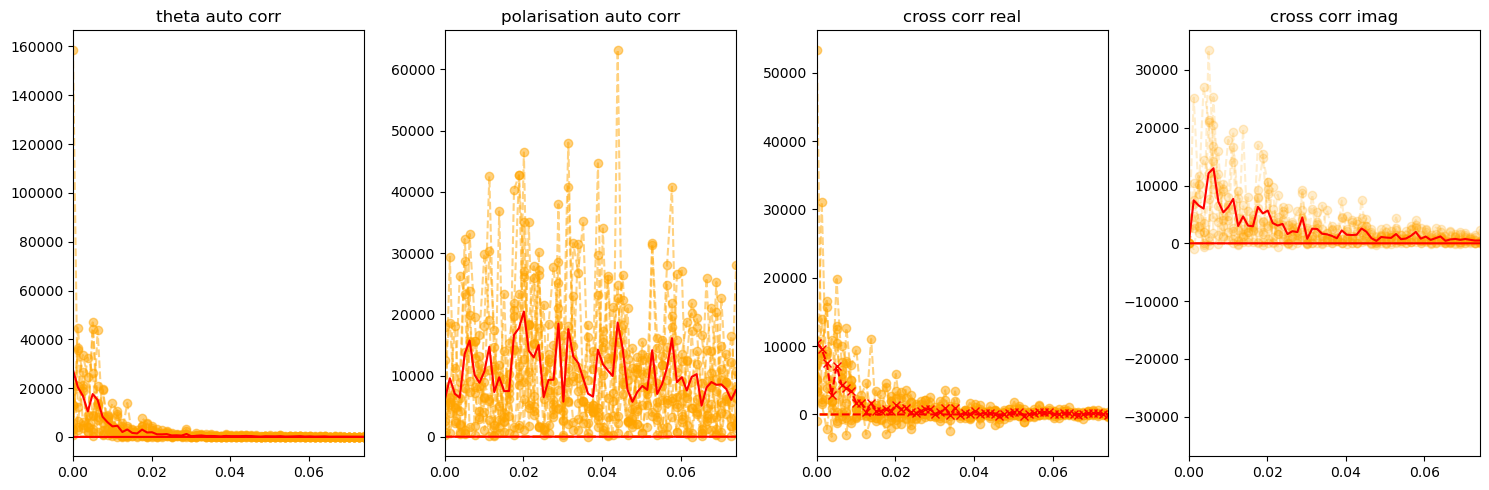

In [31]:
fig, axs = plt.subplots(1, 4, sharex=True, figsize=(15, 5))
L = n_frames
sims = np.array(sims)
thetas = sims[:, 0, :]
ps = sims[:, 1, :]

omegas = np.fft.fftfreq(L)*2*np.pi

for (theta, p) in sims:
    theta_omega = np.fft.fft(theta)
    p_omega = np.fft.fft(p)
    theta_corr = np.abs(theta_omega)**2
    p_corr = np.abs(p_omega)**2
    cross_corr = np.conj(theta_omega)*p_omega
    
    axs[0].plot(omegas, theta_corr, 'o--', alpha=0.5, color='orange')
    axs[1].plot(omegas, p_corr, 'o--', alpha=0.5, color='orange')
    axs[2].plot(omegas, cross_corr.real, 'o--', alpha=0.5, color='orange')
    axs[3].plot(omegas, cross_corr.imag, 'o--', alpha=0.2, color='orange')


theta_corr = np.mean(np.abs(np.fft.fft(thetas))**2, axis=0)
axs[0].plot(omegas, theta_corr, color='red')
axs[0].set_title('theta auto corr')


p_corr = np.mean(np.abs(np.fft.fft(ps))**2, axis=0)
axs[1].plot(omegas, p_corr, color='red')
axs[1].set_title('polarisation auto corr')

cross_corr = np.mean(np.conjugate(np.fft.fft(thetas))*np.fft.fft(ps), axis=0)
axs[2].plot(omegas, cross_corr.real, 'x--', color='red')

axs[2].set_title('cross corr real')
axs[3].plot(omegas, cross_corr.imag, color='red')
axs[3].set_title('cross corr imag')

print(cross_corr[1])


axs[0].set_xlim([0, max(omegas[:60])])
plt.tight_layout()
plt.show()  